<a href="https://colab.research.google.com/github/mrigankpawagi/EfficientAttention-TermPaper/blob/main/Efficient_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contributors: Rohit Jorige, Mrigank Pawagi, Nagasai, Sahil Chaudhary

**Efficient Attention**

The dominant sequence transduction models are based on complex recurrent or convulational neural networks that include an encoder and decoder. Vashwani et. al. proposed new simple network architecture, the Transformer based solely on attention mechanism dispensing with recurrence and convulations entirely. There is a scope of improvement on the mechanism proposed by vaswant et. al.

Attention is a very important mechanism introduce in the field of LLMs and understanding the improvement in attention is very important. The time complexity of simple attention mechanism is quadratic in nature and its a problematic time complexity for a very large number of data. Thus, Approv vyas et. al. proposed a linear transformer for the same introducing kernels to similarity function.

This Google Collab includes the experiments done around
1. Attention
2. Linear Transformer
3. Improving attention using LoRA
4. (And others???)

We have tried various experiments around MNIST, cifar-10 and compare the time required to perform forward and backward pass for variety of sequence lengths and batch sizes.

**Credits**
1. https://github.com/idiap/fast-transformers?tab=readme-ov-file
2. https://github.com/lucidrains/linear-attention-transformer
3. https://github.com/EugenHotaj/pytorch-generative/blob/master/pytorch_generative/nn/attention.py
4. https://github.com/davidsvy/cosformer-pytorch
5. https://github.com/kyle-gao/TF_Transformer

**Papers Followed:**
1. Attention is all you need: https://arxiv.org/pdf/1706.03762.pdf
2. Transformers are RNNs: https: //arxiv.org/pdf/2006.16236.pdf
3. LoRA: https://arxiv.org/pdf/2106.09685.pdf

# Installation and First Steps
The installation is directly from PyPI. This will take several minutes since it compiles several custom CUDA kernels, not only for linear autoregressive attention. Maybe grab a coffee (if you are into these things).

In [6]:
!pip install -v pytorch-fast-transformers

Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 2.3 MB/s eta 0:00:00
  Running command python setup.py egg_info
  No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
  running egg_info
  creating /tmp/pip-pip-egg-info-imkx4gxj/pytorch_fast_transformers.egg-info
  writing /tmp/pip-pip-egg-info-imkx4gxj/pytorch_fast_transformers.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-imkx4gxj/pytorch_fast_transformers.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-imkx4gxj/pytorch_fast_transformers.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-imkx4gxj/pytorch_fast_transformers.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-imkx4gxj/pytorch_fast_transformers.egg-info/SOURCES.txt'
  /usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:500: UserWarning: Attempted to use ninja as the 

Try validating freshly installed package by creating a small transformer encoder and running it on dummy data.

In [43]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader


In [44]:
#Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 64
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)


Positional Encoding: We nust have a encoding for the input tensor containg the embedding for the sequence elements and current position index in the sequence

In [3]:
train_x=train_x.astype('float32')/255
test_x=test_x.astype('float32')/255


In [4]:
class ImagePositionalEncoding(torch.nn.Module):
  def __init__(self, d_model, image_size=28):
    super(ImagePositionalEncoding, self).__init__()
    self.d_model = d_model
    self.conv_x = torch.nn.Conv2d(1, d_model // 2, kernel_size=3, padding=1)
    self.conv_y = torch.nn.Conv2d(1, d_model // 2, kernel_size=3, padding=1)

  def forward(self, x):
    # Assumes input x is a tensor of shape (batch_size, channels, image_size, image_size)
    pos_x = torch.arange(0, x.shape[2], dtype=torch.float).view(1, 1, -1, 1) / (x.shape[2] - 1)
    pos_y = torch.arange(0, x.shape[3], dtype=torch.float).view(1, 1, 1, -1) / (x.shape[3] - 1)
    pos_x = self.conv_x(pos_x.repeat(x.shape[0], 1, 1, 1))
    pos_y = self.conv_y(pos_y.repeat(x.shape[0], 1, 1, 1))
    pos = torch.cat([pos_x, pos_y], dim=1)
    return x + pos


In [5]:

pos_encoder = ImagePositionalEncoding(d_model=256)
image_batch = torch.from_numpy(train_x[:batch_size]).unsqueeze(1).float()  # Convert to PyTorch tensor
encoded_images = pos_encoder(image_batch)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 28 but got size 1 for tensor number 1 in the list.

In [7]:
from fast_transformers.builders import TransformerEncoderBuilder
from fast_transformers.masking import LengthMask, TriangularCausalMask
import torch

model = TransformerEncoderBuilder.from_kwargs(
    n_layers=4,
    n_heads=4,
    feed_forward_dimensions=128,
    query_dimensions=32,
    value_dimensions=32,
    attention_type="full" # this means normal softmax attention
).get()

x = torch.rand(
    10,  # batch size
    100, # sequence length
    128  # feature dimensions
)
y = model(x) # calling without masks which means attend to everything
y = model(
    x,
    attn_mask=TriangularCausalMask(100),   # causal masking
    length_mask=LengthMask(torch.tensor([
        100, 70, 60, 30, 80, 100,          # The sequence length for every
        50, 40, 10, 20                     # sample in the batch
    ]))
)
print("If you reached here, everything works", y.shape)

If you reached here, everything works torch.Size([10, 100, 128])


#Autoregressive Generation for MNIST

We define two modules for autoregressive image generation for general purposes. One uses a recurrent formulation(since we are trying to prove Linear Transformers are RNNS) AND the other similar to the default PyTourch implementation that just accepts the whole sequence.

Both of the implementation involves wrapping a transformer with an input embedding layer and a prediction layer.

In [8]:
import math
from fast_transformers.builders import RecurrentEncoderBuilder

class RecurrentGenerator(torch.nn.Module):
    class PositionalEncoding(torch.nn.Module):
        def __init__(self, d_model, dropout=0.0, max_len=5000):
            super(RecurrentGenerator.PositionalEncoding, self).__init__()
            self.dropout = torch.nn.Dropout(p=dropout)
            self.d_model = d_model
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0)
            self.register_buffer('pe', pe)

        def forward(self, x, i):
            pos_embedding =  self.pe[0, i:i+1]
            x = torch.cat(
                [x, pos_embedding.expand_as(x)],
                dim=1
            )
            return self.dropout(x)

    def __init__(self, d_model, sequence_length, mixtures,
                 attention_type="full", n_layers=4, n_heads=4,
                 d_query=32, dropout=0.1, softmax_temp=None,
                 attention_dropout=0.1):
        super(RecurrentGenerator, self).__init__()

        self.pos_embedding = self.PositionalEncoding(
            d_model//2,
            max_len=sequence_length
        )
        self.value_embedding = torch.nn.Embedding(
            256,
            d_model//2
        )
        self.transformer = RecurrentEncoderBuilder.from_kwargs(
            attention_type=attention_type,
            n_layers=n_layers,
            n_heads=n_heads,
            feed_forward_dimensions=n_heads*d_query*4,
            query_dimensions=d_query,
            value_dimensions=d_query,
            dropout=dropout,
            softmax_temp=softmax_temp,
            attention_dropout=attention_dropout
        ).get()
        self.predictor = torch.nn.Linear(
            d_model,
            mixtures * 3
        )

    def forward(self, x, i=0, memory=None):
        x = x.view(x.shape[0])
        x = self.value_embedding(x)
        x = self.pos_embedding(x, i)
        y_hat, memory = self.transformer(x, memory)
        y_hat = self.predictor(y_hat)

        return y_hat, memory


In [9]:
class Generator(torch.nn.Module):
    class PositionalEncoding(torch.nn.Module):
        def __init__(self, d_model, dropout=0.0, max_len=5000):
            super(Generator.PositionalEncoding, self).__init__()
            self.dropout = torch.nn.Dropout(p=dropout)
            self.d_model = d_model
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.unsqueeze(0)
            self.register_buffer('pe', pe)

        def forward(self, x):
            pos_embedding =  self.pe[:, :x.size(1), :]
            pos_embedding = torch.repeat_interleave(pos_embedding, x.shape[0], dim=0)
            x =  torch.cat([x, pos_embedding], dim=2)
            return self.dropout(x)

    def __init__(self, d_model, sequence_length, mixtures,
                 attention_type="full", n_layers=4, n_heads=4,
                 d_query=32, dropout=0.1, softmax_temp=None,
                 attention_dropout=0.1):
        super(Generator, self).__init__()

        self.pos_embedding = self.PositionalEncoding(
            d_model//2,
            max_len=sequence_length
        )
        self.value_embedding = torch.nn.Embedding(
            256,
            d_model//2
        )

        self.transformer = TransformerEncoderBuilder.from_kwargs(
            attention_type=attention_type,
            n_layers=n_layers,
            n_heads=n_heads,
            feed_forward_dimensions=n_heads*d_query*4,
            query_dimensions=d_query,
            value_dimensions=d_query,
            dropout=dropout,
            softmax_temp=softmax_temp,
            attention_dropout=attention_dropout
        ).get()

        hidden_size = n_heads*d_query
        self.predictor = torch.nn.Linear(
            hidden_size,
            mixtures * 3
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.value_embedding(x)
        x = self.pos_embedding(x)
        triangular_mask = TriangularCausalMask(x.shape[1], device=x.device)
        y_hat = self.transformer(x, attn_mask=triangular_mask)
        y_hat = self.predictor(y_hat)

        return y_hat

In [10]:
def sample_mol(y_hat, num_classes=256):
    """Sample from mixture of logistics.

    y_hat: NxC where C is 3*number of logistics
    """
    assert len(y_hat.shape) == 2

    N = y_hat.size(0)
    nr_mix = y_hat.size(1) // 3

    probs = torch.softmax(y_hat[:, :nr_mix], dim=-1)
    means = y_hat[:, nr_mix:2 * nr_mix]
    scales = torch.nn.functional.elu(y_hat[:, 2*nr_mix:3*nr_mix]) + 1.0001

    indices = torch.multinomial(probs, 1).squeeze()
    batch_indices = torch.arange(N, device=probs.device)
    mu = means[batch_indices, indices]
    s = scales[batch_indices, indices]
    u = torch.rand(N, device=probs.device)
    preds = mu + s*(torch.log(u) - torch.log(1-u))

    return torch.min(
        torch.max(
            torch.round((preds+1)/2*(num_classes-1)),
            preds.new_zeros(1),
        ),
        preds.new_ones(1)*(num_classes-1)
    ).long().view(N, 1)


def predict_with_recurrent(model, images, n):
    memory = None
    y_hat = []
    x_hat = []

    with torch.no_grad():
        for i in range(n):
            x_hat.append(images[:, i:i+1])
            yi, memory = model(x_hat[-1], i=i, memory=memory)
            y_hat.append(yi)

        for i in range(n, images.shape[1]):
            x_hat.append(sample_mol(y_hat[-1], 256))
            yi, memory = model(x_hat[-1], i=i, memory=memory)
            y_hat.append(yi)

        x_hat.append(sample_mol(y_hat[-1], 256))
        x_hat = torch.stack(x_hat, dim=1)

    return x_hat


def predict(model, images, n):
    N, L = images.shape
    x_hat = images.new_zeros(N, L+1, dtype=torch.long)
    x_hat[:, :n] = images[:, :n]
    with torch.no_grad():
        for i in range(n, L):
            y_hat = model(x_hat[:, :i])
            x_hat[:, i:i+1] = sample_mol(y_hat[:,-1,:], 256)
        x_hat[:, -1:] = sample_mol(y_hat[:,-1,:], 256)
    return x_hat

#Load Pretrained Models for MNIST

Angelos Katharopoulos et. al has already trained the model. So we are just importing the model from google drive which they have already pretrain.

In [11]:
import io
import requests

LINEAR_MODEL = "https://drive.google.com/uc?export=download&id=17fc94TzytTdAwNMVCE7qOg75-CWLGi_p"
SOFTMAX_MODEL = "https://drive.google.com/uc?export=download&id=1L47Ode6GxCMQbVMK33_ANjCu2iA4rf8l"

linear_weights = torch.load(io.BytesIO(requests.get(LINEAR_MODEL).content))
softmax_weights = torch.load(io.BytesIO(requests.get(SOFTMAX_MODEL).content))

And Now, we can create the model and generate some images. Note that we are creating recurrent model for softmax. This means that we save all keys and values to avoid computing again which is not something easily done for every transformer implementation.

On the other hand, for linear attention the state has fixed size and it is natural to implement it as a recurrent model since the Attention is causal masked.

#Image Generation

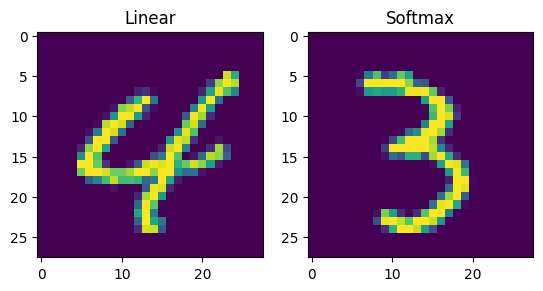

In [75]:
linear = RecurrentGenerator(256, 783, 10, "linear", 8, 8)
linear.load_state_dict(linear_weights)
linear.eval()
full = RecurrentGenerator(256, 783, 10, "full", 8, 8)
full.load_state_dict(softmax_weights)
full.eval()


images_linear = predict_with_recurrent(linear, torch.zeros(1, 783, dtype=torch.int64), 1)
images_full = predict_with_recurrent(full, torch.zeros(1, 783, dtype=torch.int64), 1)

import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].set_title("Linear")
ax[0].imshow(images_linear[0].cpu().numpy().reshape(28, 28))
ax[1].set_title("Softmax")
ax[1].imshow(images_full[0].cpu().numpy().reshape(28, 28))

In [92]:
print(torch.zeros(1, 783, dtype=torch.int64).shape)
print(images_linear.shape)

torch.Size([1, 783])
torch.Size([1, 784, 1])


#Image Completion

We will sample any 5 numbers from 0-10 and access the image corresponding to it and give it as a input to predict_with_recurrent to check if it can regenerate the same image given half of the information about the image. We choose 0,1,2,3,4 to test on experiment around the occulated data.

The following code takes the dataset for the num 0,1,2,3,4 and visualises the dataset for the same

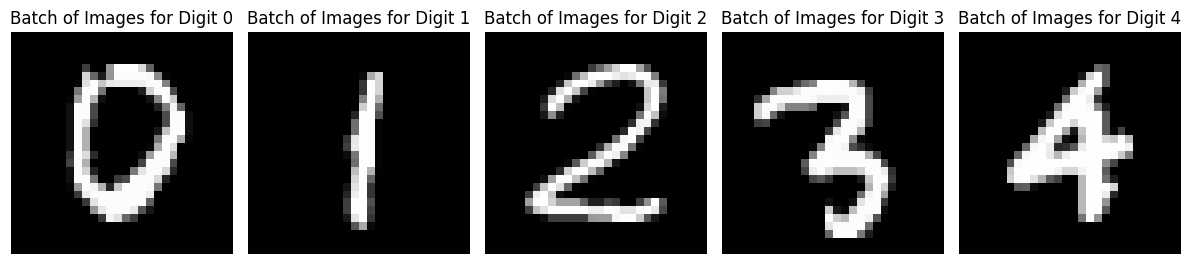

In [58]:

target_digits=[0,1,2,3,4]
digit_dataloaders = {digit: None for digit in target_digits}

# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

for digit in target_digits:
  # Filter data for the current digit
  digit_indices = (train_dataset.targets == digit).nonzero()[:, 0]
  digit_dataset_subset = torch.utils.data.Subset(train_dataset, digit_indices)

  # Create a DataLoader for the filtered data
  digit_dataloader = DataLoader(digit_dataset_subset, batch_size=64, shuffle=True)

  digit_dataloaders[digit]=digit_dataloader

dataset=[]
for digit in target_digits:
    images, labels = next(iter(digit_dataloaders[digit]))
    dataset.append(images)


# Visualize a few samples from each batch of images
fig, axes = plt.subplots(1, len(dataset), figsize=(12, 3))  # Adjust figsize as needed

for i, images in enumerate(dataset):
  # Visualize the first image in the batch
  for j in range(1):
    axes[i].imshow(images[j].squeeze(), cmap='gray')
    # Add labels for better clarity
    axes[i].set_title(f"Batch of Images for Digit {target_digits[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Create occulated images of the dataset. We will now only store information about half of this image. or say, stop the data visualisation at just half.

In [143]:
def occlude_half_image(image):
  """
  Reduces image dimension by half by slicing (top half by default).

  Args:
      image: A PyTorch tensor representing the image (channels, height, width).

  Returns:
      A PyTorch tensor representing the half-sized image.
  """

  # Get image dimensions
  channels, height, width = image.shape

  # Select half of the image (top half by default)
  half_image = image[:, :height // 2, :]  # Modify slicing for bottom half

  return half_image
# def occlude_half_image(image):
#     """
#     Ocludes half of the image (top half by default).

#     Args:
#         image: A PyTorch tensor representing the image (channels, height, width).

#     Returns:
#         A PyTorch tensor representing the occluded image.
#     """

#     # Get image height
#     image_size = image.shape[1]

#     # Create a mask with the same size as the image
#     mask = torch.zeros_like(image)

#     # Set half of the mask to 1 (top half by default)
#     mask[:, :image_size // 2] = 1

#     # Apply the mask to occlude half of the image
#     return image * mask


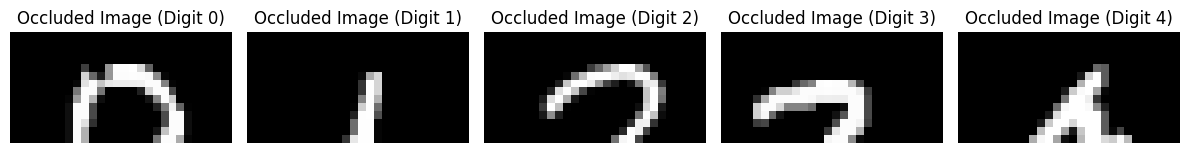

In [144]:
# Assuming you have the `dataset` list containing image tensors

# Visualize a few samples from each batch of images
fig, axes = plt.subplots(1, len(dataset), figsize=(12, 3))  # Adjust figsize as needed

for i, images in enumerate(dataset):
    # Occlude the first image (or modify the index)
    occluded_image = occlude_half_image(images[0])

    # Visualize the occluded image
    axes[i].imshow(occluded_image.squeeze(), cmap='gray')
    axes[i].set_title(f"Occluded Image (Digit {target_digits[i]})")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [145]:
occluded_dataset = []

for images in dataset:
    occluded_image = occlude_half_image(images[0])
    occluded_dataset.append(occluded_image)



Now test the model

In [146]:
def prepare_image_for_model(image):
  """
  Flattens the image tensor for model input.

  Args:
      image: A PyTorch tensor representing the image (channels, height, width).

  Returns:
      A PyTorch tensor representing the flattened image (channels * height * width).
  """

  # Assuming the image has a single channel (modify if channels > 1)
  return image.view(image.shape[0], -1)  # Flatten all dimensions except the first (batch size)


In [147]:
flatten_occluded_dataset=[]
for images in occluded_dataset:
  flatten_image=prepare_image_for_model(images)
  flatten_occluded_dataset.append(flatten_image)
  # flatten_occluded_dataset.append(flatten_image[:, :-1])
print(flatten_occluded_dataset[0].shape)

torch.Size([1, 392])
